In [ ]:
import numpy as np
import os
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import joblib
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
# from sklearn.neural_network import MLPClassifier
# from sklearn.model_selection import GridSearchCV

In [ ]:
def load_images_and_labels(folder): # SD: basically the same as clustering file - look at comments in that file
    X, y = [], []
    class_names = sorted(os.listdir(folder))
    label_map = {cls_name: idx for idx, cls_name in enumerate(class_names)}
    
    for cls_name in class_names:
        cls_folder = os.path.join(folder, cls_name)
        if not os.path.isdir(cls_folder): # SD: added this line to skip if it can't find a folder
            continue
        for fname in os.listdir(cls_folder):
            img_path = os.path.join(cls_folder, fname)
            try:
                with Image.open(img_path) as img:
                    img = img.convert('L').resize(image_size)
                    X.append(np.array(img).flatten())
                    y.append(label_map[cls_name])
            except (OSError, ValueError):
                pass
    
    return np.array(X), np.array(y), label_map

In [42]:
accuracies = []

In [ ]:
# SD: when running q-transform change the q_value and run the lines below
q_value = 128
image_size = (224, 224)
train_folder = f"q{q_value}/train"
val_folder = f"q{q_value}/validation"
test_folder = f"q{q_value}/test"
output_model_file = f"random_forest_q{q_value}.pkl"
output_proba_file = f"probs_q{q_value}.pkl"

In [ ]:
# SD: when running log-mel spectrogram run the lines below
image_size = (224, 224)
train_folder = f"mel/train"
val_folder = f"mel/validation"
test_folder = f"mel/test"
output_model_file = f"random_forest_mel.pkl"
output_proba_file = f"probs_mel.pkl"

In [ ]:
X_train, y_train, label_map = load_images_and_labels(train_folder) # SD: load in all the data
X_val, y_val, _ = load_images_and_labels(val_folder)
X_test, y_test, _ = load_images_and_labels(test_folder)

# SD: merge val and test so we have bigger testing dataset
X_test_full = np.vstack((X_val, X_test))
y_test_full = np.hstack((y_val, y_test))

In [ ]:
clf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1) # SD: run random forest classifier
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test_full)
accuracy = accuracy_score(y_test_full, y_pred)
accuracies.append(accuracy) # SD: append accuracy to list to have list at the end with all accuracy values
print(f"Accuracy on test set: {accuracy:.4f}") # SD: or just... write the accuracies down when you run them individually

joblib.dump(clf, output_model_file) # SD: save fitted random forest model

probs = clf.predict_proba(X_test_full)
joblib.dump((probs, y_test_full, label_map), output_proba_file) # SD: I was saving probabilities of being classified as each glitch type because I was using it with a MLP Classifier. But couldn't get it working well enough by the deadline (not that I had the space in the paper to write about it anyways). So, could remove these 2 lines here.

Accuracy on test set: 0.9059


['probs_mel.pkl']

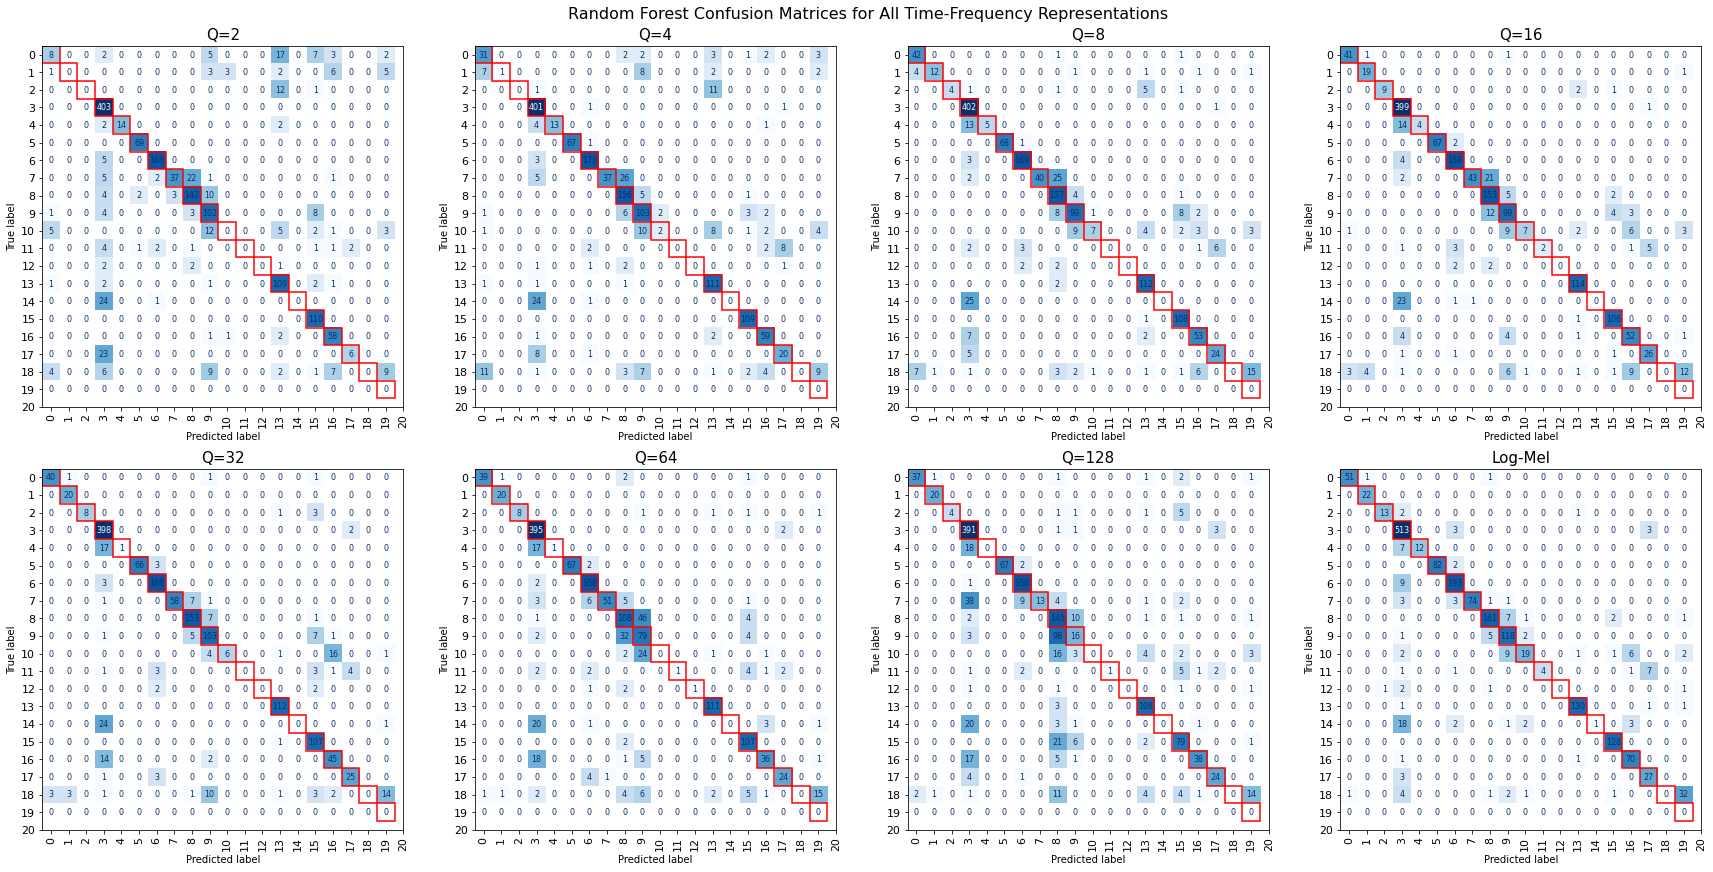

In [ ]:
# SD: making figure with confusion matrix of all models
q_values = [2, 4, 8, 16, 32, 64, 128]
special_name = "mel"
all_embeddings = q_values + [special_name]  # SD: 8 in total

labels = ['1080Lines', '1400Ripples', 'Air_Compressor', 'Blip', 'Chirp', 'Extremely_Loud', 
          'Koi_Fish', 'Light_Modulation', 'Low_Frequency_Burst', 'Low_Frequency_Lines', 
          'No_Glitch', 'None_of_the_Above', 'Paired_Doves', 'Power_Line', 'Repeating_Blips', 
          'Scattered_Light', 'Scratchy', 'Tomte', 'Violin_Mode', 'Wandering_Line', 'Whistle']

# SD: create figure
fig, axes = plt.subplots(2, 4, figsize=(24, 12), constrained_layout=True)
axes = axes.flatten()

for idx, q_value in enumerate(all_embeddings):
    ax = axes[idx]

    # SD: load in model and data
    if q_value == special_name:
        val_folder = f"mel/validation"
        test_folder = f"mel/test"
        clf = joblib.load(f"random_forest_mel.pkl")
        title = "Log-Mel"
    else:
        val_folder = f"q{q_value}/validation"
        test_folder = f"q{q_value}/test"
        clf = joblib.load(f"random_forest_q{q_value}.pkl")
        title = f"Q={q_value}"

    X_val, y_val, _ = load_images_and_labels(val_folder)
    X_test, y_test, _ = load_images_and_labels(test_folder)
    X_test_full = np.vstack((X_val, X_test))
    y_test_full = np.hstack((y_val, y_test))

    # SD: predict on test set
    y_pred = clf.predict(X_test_full)
    
    present_labels = np.unique(np.concatenate([y_test_full, y_pred]))  # SD: all labels seen in test or prediction
    label_names = [list(label_map.keys())[list(label_map.values()).index(lbl)] for lbl in present_labels] # SD: removing label names which are not seen by the model at all
    
    # SD: confusion matrix
    cm = confusion_matrix(y_test_full, y_pred, labels=present_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    
    disp.plot(ax=ax, cmap='Blues', colorbar=False, xticks_rotation='vertical', im_kw={"norm":LogNorm(vmin=1, vmax=cm.max())}) # SD: making colourbar log scale
    ax.set_title(title, fontsize=15)
    
    for text in disp.text_.ravel():
        text.set_fontsize(8) # SD: making numbers smaller because the 3 digit numbers overflow into other boxes if bigger and become unreadable

    # SD: set x and y ticks to numbers instead of class names - save space as this figure is already very big and dense
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    
    ax.set_xticklabels(np.arange(len(labels)), fontsize=11)
    ax.set_yticklabels(np.arange(len(labels)), fontsize=11)

    # SD: highlight diagonal
    for i in range(len(cm)):
        ax.add_patch(plt.Rectangle((i-0.5, i-0.5), 1, 1, fill=False, edgecolor='red', lw=1.5))

plt.suptitle("Random Forest Confusion Matrices for All Time-Frequency Representations", fontsize=16)
plt.savefig("rf_combined_confusion_matrices.pdf", dpi=300, bbox_inches='tight')
plt.show()

Had a bunch of stuff trying out neural net MLP classifiers after this... I've removed it because it did not work, and is not in the paper.